In [1]:
from langchain_community.vectorstores import Qdrant

In [2]:
from qdrant_client import QdrantClient, models

client = QdrantClient(path="Qdrant_db")

In [3]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [4]:
collection_name = "AML_act"
qdrant =  Qdrant(client, collection_name, embedding_model)

In [5]:
qdrant_retriever = qdrant.as_retriever()

In [6]:
query = "do i need transfer information when receiving an electronic funds transfer?"
qdrant_retriever.invoke(query)

[Document(page_content='• \nElectronic funds transfer instructions must include certain \ninformation about the origin of the transferred money. \nAuthorised Version C2023C00383 registered 31/10/2023', metadata={'source': 'Data/C2023C00383.pdf', 'file_path': 'Data/C2023C00383.pdf', 'page': 145, 'total_pages': 380, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Aspose Ltd.', 'producer': 'Aspose.PDF for .NET 22.3.0', 'creationDate': "D:20231030233312+00'00'", 'modDate': "D:20231030233758+00'00'", 'trapped': '', '_id': 'c1c8fc0171174a4a9735884c62aaafd9', '_collection_name': 'AML_act'}),
 Document(page_content='the notice) to include required transfer information in all \nfuture electronic funds transfer instructions passed on by the \nordering institution to the beneficiary institution; \nthe beneficiary institution must comply with the direction within \n10 business days after the day on which the direction is given. \nReport by beneficiary ins

In [7]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-3.5-turbo")  #, temperature=0.0

In [8]:
from langchain_core.prompts import ChatPromptTemplate

In [9]:
system_message = "You are a helpful assistante, experienced lawyer and an expert reading SECURITIES AND EXCHANGE COMMISSION documents"

In [10]:
RAG_PROMPT = """

CONTEXT:
{context}

QUERY:
{question}

Answer the query above using the context provided. If you don't know the answer responde with: I don't know
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [11]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=qdrant_retriever, llm=openai_chat_model)


In [12]:
rag_prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="\n\nCONTEXT:\n{context}\n\nQUERY:\n{question}\n\nAnswer the query above using the context provided. If you don't know the answer responde with: I don't know\n"))])

In [13]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | advanced_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | openai_chat_model, "context": itemgetter("context")}
)


"What was the total value of 'Cash and cash equivalents' as of December 31, 2023?"

"Who are Meta's 'Directors' (i.e., members of the Board of Directors)?"

In [14]:
retr = (rag_prompt | openai_chat_model)
resp = retr.invoke({"question" : "What was the total value ", "context": "sdfsfsdfs", "system_message" : "dfgdfg"})
resp

AIMessage(content="I don't know", response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 48, 'total_tokens': 52}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c09eb19f-2452-48de-b2b3-dfbf4f7ca3db-0')

In [15]:
response = retrieval_augmented_qa_chain.invoke({"question" : "where are  the aml ctf rules?"})
response["response"].content

'The AML/CTF Rules are prescribed by the AUSTRAC CEO through writing, as stated in Division 7 of the Anti-Money Laundering and Counter-Terrorism Financing Act 2006.'

In [16]:
response

{'response': AIMessage(content='The AML/CTF Rules are prescribed by the AUSTRAC CEO through writing, as stated in Division 7 of the Anti-Money Laundering and Counter-Terrorism Financing Act 2006.', response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 1332, 'total_tokens': 1375}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1d11a983-a1e5-4cec-8af9-52fbec798271-0'),
 'context': [Document(page_content='Administration  Part 16 \nAML/CTF Rules  Division 7 \n \nSection 229 \n \n \nAnti-Money Laundering and Counter-Terrorism Financing Act 2006 \n321 \nCompilation No. 56 \nCompilation date: 20/10/2023 \nRegistered: 31/10/2023 \n \nDivision 7—AML/CTF Rules \n229  AML/CTF Rules \n \n(1) The AUSTRAC CEO may, by writing, make rules (the AML/CTF \nRules) prescribing matters required or permitted by any other', metadata={'source': 'Data/C2023C00383.pdf', 'file_path': 'Data/C2023C00383.pdf', 'page': 336, 'total_

Q: do i need transfer information when receiving an electronic funds transfer
A:

Q:what session refers to receiving an electronic funds transfer?
A:'The session that refers to receiving an electronic funds transfer is the "Retention of records about electronic funds transfer instructions" as mentioned in the provided context.'

Q:Where can I find the specific requirements and procedures for Customer Due Diligence (CDD) under AML/CTF Act 2006 ?
A:'You can find the specific requirements and procedures for Customer Due Diligence (CDD) under the AML/CTF Act 2006 in Part 2, Division 6, Section 36 of the Anti-Money Laundering and Counter-Terrorism Financing Act 2006.'




In [10]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

from langchain.tools.retriever import create_retriever_tool

In [ ]:
retreiver_tool = create_retriever_tool(
    advanced_retriever,
    "search_aml_act_retriever",
    "Searches and returns excerpts from the aml act in australia.",
)

In [19]:
tool_belt = [DuckDuckGoSearchRun(), retreiver_tool]   #  

In [21]:
wrapper = DuckDuckGoSearchAPIWrapper(region="en-en", max_results=1)
search2 = DuckDuckGoSearchRun(api_wrapper=wrapper)
search2.run("water")

'water, a substance composed of the chemical elements hydrogen and oxygen and existing in gaseous, liquid, and solid states. It is one of the most plentiful and essential of compounds.A tasteless and odourless liquid at room temperature, it has the important ability to dissolve many other substances. Indeed, the versatility of water as a solvent is essential to living organisms.'

In [21]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tool_belt)

In [22]:
model_aml = ChatOpenAI(temperature=0)

In [23]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tool_belt]
model_aml = model_aml.bind_functions(functions)

In [24]:
functions

[{'name': 'duckduckgo_search',
  'description': 'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'description': 'search query to look up',
     'type': 'string'}},
   'required': ['query']}},
 {'name': 'search_aml_act_retriever',
  'description': 'Searches and returns excerpts from the aml act in australia.',
  'parameters': {'type': 'object',
   'properties': {'query': {'description': 'query to look up in retriever',
     'type': 'string'}},
   'required': ['query']}}]

In [25]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

In [26]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
  messages = state["messages"]
  response = model_aml.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

In [27]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

In [28]:
workflow.set_entry_point("agent")

In [29]:
def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)

In [30]:
workflow.add_edge("action", "agent")

In [31]:
app = workflow.compile()

In [32]:
type(app)

langgraph.graph.state.CompiledStateGraph

In [33]:
def print_messages(messages):
  next_is_tool = False
  initial_query = True
  for message in messages["messages"]:
    if "function_call" in message.additional_kwargs:
      print()
      print(f'Tool Call - Name: {message.additional_kwargs["function_call"]["name"]} + Query: {message.additional_kwargs["function_call"]["arguments"]}')
      next_is_tool = True
      continue
    if next_is_tool:
      print(f"Tool Response: {message.content}")
      next_is_tool = False
      continue
    if initial_query:
      print(f"Initial Query: {message.content}")
      print()
      initial_query = False
      continue
    print()
    print(f"Agent Response: {message.content}")

how is the weather in sydney? 
what is aml?
where are  the aml ctf rules?

In [42]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="my name is miguel")]}  #where are  the aml ctf rules

messages = app.invoke(inputs)

print_messages(messages)

Initial Query: my name is miguel


Agent Response: Hello Miguel! How can I assist you today?


In [43]:
messages

{'messages': [HumanMessage(content='my name is miguel', id='979fc373-9a5d-4db0-aea6-94c6b3682391'),
  AIMessage(content='Hello Miguel! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 123, 'total_tokens': 134}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b95f72f6-86e4-4b17-89ff-a15cc896bbac-0')]}

In [41]:
messages

{'messages': [HumanMessage(content='where are  the aml ctf rules', id='f11aa083-e46d-4a53-9621-9d07deec01da'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"AML CTF rules"}', 'name': 'search_aml_act_retriever'}}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 127, 'total_tokens': 149}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-8810ab57-fe93-413e-aabc-261bb68634ff-0'),
  FunctionMessage(content='(3) To avoid doubt, AML/CTF Rules made for the purposes of \nparagraph 86(1)(c) may require that, if: \n \n(a) a designated service is provided to a customer specified in \nthe AML/CTF Rules; or \n \n(b) a designated service is provided to a customer in \ncircumstances specified in the AML/CTF Rules; \na special anti-money laundering and counter-terrorism financing\n\nAdministration  Part 16 \nAML/CTF Rules  Division 7 \n \nSection 229 \n \n \nAnti-Mo

In [35]:
from langchain.schema import StrOutputParser

In [36]:
my_chain = app | StrOutputParser()

In [37]:
type(my_chain)

langchain_core.runnables.base.RunnableSequence

In [38]:
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

In [39]:
chunk = {'agent': {'messages': [AIMessage(content='Hello Miguel! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 123, 'total_tokens': 134}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-05f34bde-9698-4a70-b15a-61dc15c06238-0')]}}

In [40]:
chunk["response"].content

KeyError: 'response'

In [ ]:
chunk["agent"]["messages"][0].content

'Hello Miguel! How can I assist you today?'

MERMAID.INK GRAPH GENERATOR

In [ ]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image


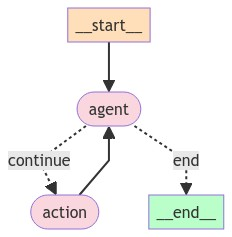

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)